In [24]:
import numpy as np
import pandas as pd
import os

import cv2
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

import warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [25]:
!nvidia-smi

Sat Feb  5 09:50:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    63W / 149W |  11077MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/cots_classifiers/data/train'
VAL_DIR = '/content/drive/MyDrive/Colab Notebooks/cots_classifiers/data/val'

### Initiale callbacks

In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('best_model.pb', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
rlop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)

callbacks = [es, mc, rlop]

### Read img files

In [28]:
names, has_cots = [], []
val_names, val_has_cots = [], []

# Append all has_cots == True
for p, dirnames, files in os.walk(os.path.join(TRAIN_DIR, str(1))):
    for file in files:
        names.append(f'1/{file}')
        has_cots.append(1)
        
# Append all has_cots == False
for p, dirnames, files in os.walk(os.path.join(TRAIN_DIR, str(0))):
    for file in files:
        names.append(f'0/{file}')
        has_cots.append(0)

for p, dirnames, files in os.walk(os.path.join(VAL_DIR, str(1))):
    for file in files:
        val_names.append(f'1/{file}')
        val_has_cots.append(1)
        
# Append all has_cots == False
for p, dirnames, files in os.walk(os.path.join(VAL_DIR, str(0))):
    for file in files:
        val_names.append(f'0/{file}')
        val_has_cots.append(0)

In [29]:
train_df = pd.DataFrame(list(zip(names, has_cots)), columns=['id', 'has_cots'])
train_df.sample(10)
val_df = pd.DataFrame(list(zip(val_names, val_has_cots)), columns=['id', 'has_cots'])
val_df.sample(10)

,id,has_cots
747,1/0_1-6866.jpg,1
430,1/1_0-9646.jpg,1
390,1/2_0-9644.jpg,1
143,1/1_0-8940.jpg,1
850,1/1_1-6896.jpg,1
161,1/0_0-9419.jpg,1
498,1/2_0-9691.jpg,1
9,1/0_0-8240.jpg,1
439,1/3_0-9660.jpg,1
1393,0/2_1-6890_1.jpg,0


In [30]:
print('Number of train samples: ', train_df.shape[0])
train_df.head()

Number of train samples:  14984


,id,has_cots
0,1/6_2-5809.jpg,1
1,1/5_2-5816.jpg,1
2,1/7_2-5803.jpg,1
3,1/4_2-5815.jpg,1
4,1/1_2-5807.jpg,1


In [31]:
print(train_df['has_cots'].value_counts())
print(val_df['has_cots'].value_counts())

1    10866
0     4118
Name: has_cots, dtype: int64
1    1032
0     459
Name: has_cots, dtype: int64


In [32]:
# train_df = train_df.sample(10_000)

### Visualize imgs

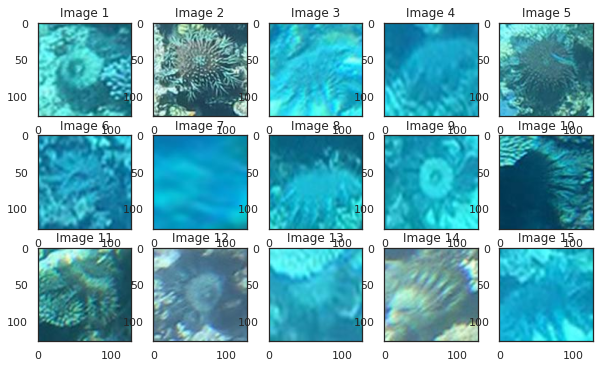

In [33]:
sns.set_style("white")
count = 1
plt.figure(figsize=[10, 10])
for col, row in train_df[train_df.has_cots == 1].sample(15).iterrows():
    img = cv2.imread(os.path.join(TRAIN_DIR, row.id))[:,:,::-1]
#     HEIGHT, WIDTH, CHANEL = img.shape[:3]
    HEIGHT, WIDTH, CHANEL = (128, 128, 3)
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

### Model parameters


In [34]:
BATCH_SIZE = 128
EPOCHS = 100
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-3
WARMUP_LEARNING_RATE = 1e-3 
N_CLASSES = train_df['has_cots'].nunique()
VALIDATION_SPLIT=0.2

In [35]:
val_df['has_cots'] = val_df['has_cots'].astype('str')

train_df['has_cots'] = train_df['has_cots'].astype('str')
train_df.head()

,id,has_cots
0,1/6_2-5809.jpg,1
1,1/5_2-5816.jpg,1
2,1/7_2-5803.jpg,1
3,1/4_2-5815.jpg,1
4,1/1_2-5807.jpg,1


### Create train / val generators

In [36]:
train_datagen=ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    # validation_split=VALIDATION_SPLIT
)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="id",
    y_col="has_cots",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    shuffle=True,
    # subset='training'
    )

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=VAL_DIR,
    x_col="id",
    y_col="has_cots",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    # subset='validation'
)

Found 14984 validated image filenames belonging to 2 classes.
Found 1491 validated image filenames belonging to 2 classes.


In [37]:
!git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd ./efficientnet_keras_transfer_learning/

fatal: destination path 'efficientnet_keras_transfer_learning' already exists and is not an empty directory.
/content/efficientnet_keras_transfer_learning


### Import Efficientnet

In [38]:
from tensorflow.keras.applications import EfficientNetB3 as Net 

conv_base = Net(weights='imagenet',include_top=False,input_shape=(HEIGHT,WIDTH,CHANEL))

In [39]:
def build_model(weights_path):
    
    model = EfficientNetB3(include_top=False, weights=weights_path)
    
    model.trainable = False
    
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = Dropout(top_dropout_rate)(x)
    x = Dense(32, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    outputs = Dense(1, activation="sigmoid", name="pred")(x)
    

    # Compile
    model = Model(model.inputs, outputs, name="EfficientNet")
    

    # Compile
    optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["binary_accuracy",AUC()])
    return model

In [40]:
from tensorflow.keras import models
from tensorflow.keras import layers

dropout_rate = 0.3
model = models.Sequential()
model.add(conv_base)
# OLD SETTING
# model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(N_CLASSES,activation="softmax", name="final_output"))
######
# NEW SETTINGS
model.add(layers.GlobalAveragePooling2D(name='avg_pool'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(N_CLASSES, activation='softmax', name='pred'))

In [41]:
conv_base.trainable = False

In [42]:
%cd ../
!ls

/content
best_model.pb  drive  efficientnet_keras_transfer_learning  sample_data


In [43]:
from tensorflow.keras import optimizers

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 4, 4, 1536)       10783535  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1536)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                49184     
                                                                 
 batch_normalization_3 (Batc  (None, 32)              

### Run warmup

In [44]:
%%time

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1).history

Epoch 1/2
117/117 [==============================] - 477s 4s/step - loss: 0.7797 - accuracy: 0.5761 - val_loss: 0.6300 - val_accuracy: 0.6946
Epoch 2/2
117/117 [==============================] - 128s 1s/step - loss: 0.6582 - accuracy: 0.6718 - val_loss: 0.6177 - val_accuracy: 0.6925
CPU times: user 4min 8s, sys: 12 s, total: 4min 20s
Wall time: 10min 6s


In [45]:
for layer in model.layers:
    layer.trainable = True

In [46]:
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 4, 4, 1536)       10783535  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1536)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                49184     
                                                                 
 batch_normalization_3 (Batc  (None, 32)              

### Train model

In [47]:
%%time

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_finetunning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks).history

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.8819
Epoch 00001: val_loss improved from inf to 3.35691, saving model to best_model.pb
INFO:tensorflow:Assets written to: best_model.pb/assets
117/117 [==============================] - 286s 2s/step - loss: 0.2825 - accuracy: 0.8819 - val_loss: 3.3569 - val_accuracy: 0.3054 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9505
Epoch 00002: val_loss did not improve from 3.35691
117/117 [==============================] - 168s 1s/step - loss: 0.1403 - accuracy: 0.9505 - val_loss: 7.6421 - val_accuracy: 0.3139 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9640
Epoch 00003: val_loss did not improve from 3.35691

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
117/117 [==============================] - 166s 1s/step - loss: 0.1015 - accuracy: 0.9640 - val_lo

### Visualize loss and acc

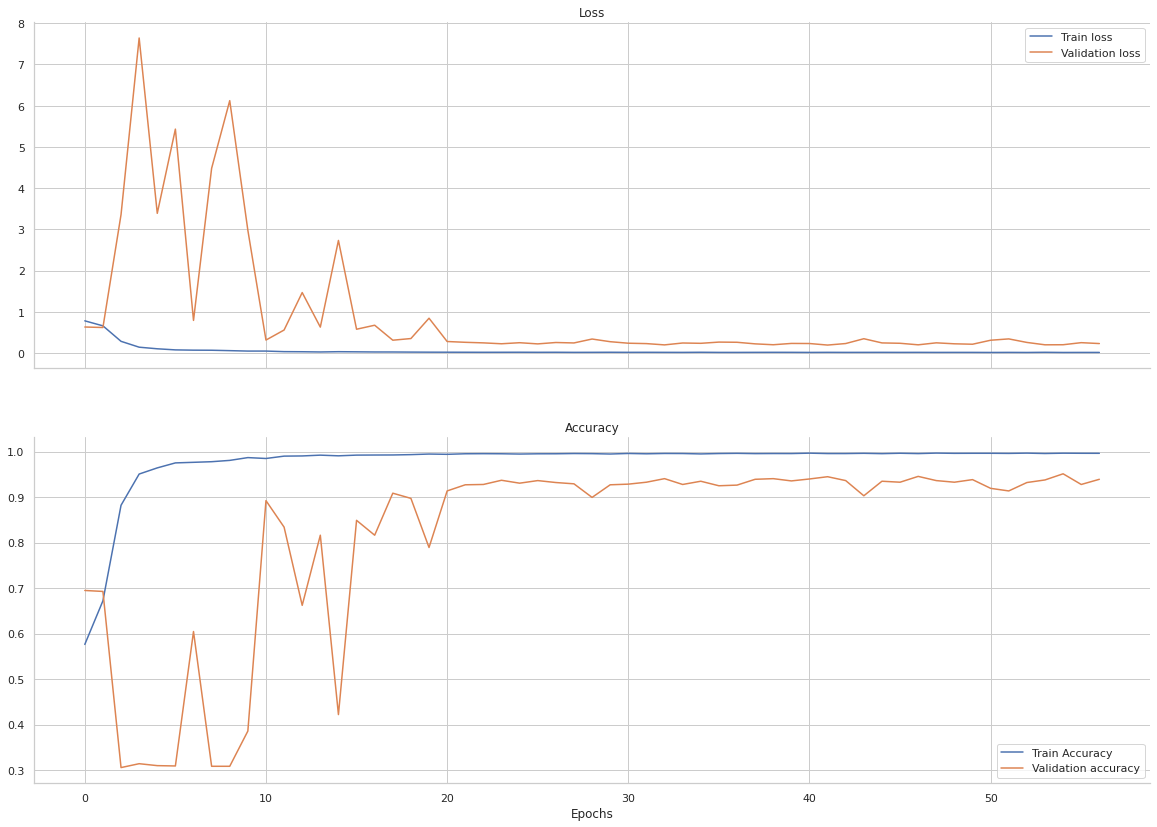

In [48]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Load best checkpoint and evaluate

In [49]:
from keras.models import load_model as lm

efficientnet_cp = '/content/drive/MyDrive/Colab Notebooks/cots_classifiers/data/models/best_model.pb'
model = lm(efficientnet_cp)

In [50]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train_df,
        directory = TRAIN_DIR,
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 14984 validated image filenames.


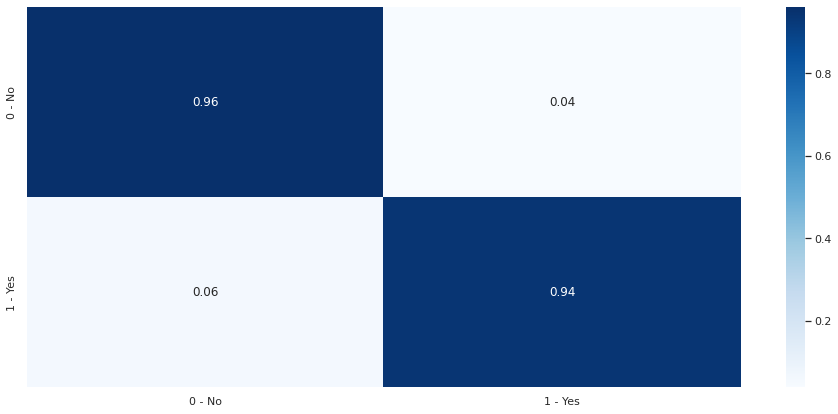

CPU times: user 308 ms, sys: 113 ms, total: 422 ms
Wall time: 322 ms


In [51]:
%%time
labels = ['0 - No', '1 - Yes']
cnf_matrix = confusion_matrix(train_df['has_cots'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [52]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(  
        dataframe=val_df,
        directory = VAL_DIR,
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_COMPLETE)
test_preds = [np.argmax(pred) for pred in test_preds]

Found 1491 validated image filenames.


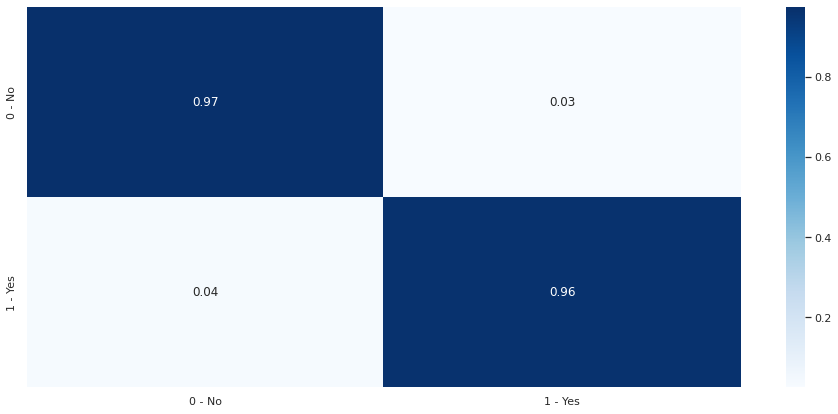

CPU times: user 314 ms, sys: 109 ms, total: 423 ms
Wall time: 304 ms


In [53]:
%%time
labels = ['0 - No', '1 - Yes']
cnf_matrix = confusion_matrix(val_df['has_cots'].astype('int'), test_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()